## Create and test ion channel model

In [1]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_inact_kin_80,
                                        sakakibara_recov,
                                        sakakibara_recov_100,
                                        sakakibara_recov_kin)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/ina_simple.mmt'

In [29]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_iv_Nao5,
                                                sakakibara_act,
                                                sakakibara_inact)

In [30]:
assert len(observations)==len(summary_statistics(model({})))

In [31]:
print(summary_statistics(model({})))

{'0': -5.772358576637345e-19, '1': -4.6563928868919943e-17, '2': -2.480662907831139e-15, '3': -8.287721643035593e-14, '4': -2.186397534026259e-12, '5': -5.2774071751363506e-11, '6': -8.354526358530347e-10, '7': -1.1773798546140507e-08, '8': -1.487459291051481e-07, '9': -9.833573307550843e-07, '10': -1.2391438444132527e-09, '11': 0.00011112235638062419, '12': 0.0010405964442601024, '13': 0.005705355302143213, '14': 0.006806541908597841, '15': 3.8568997672846686e-19, '16': 3.9874289614505104e-17, '17': 2.536977278397352e-15, '18': 1.1879478856910133e-13, '19': 4.0699829822414276e-12, '20': 1.0690257441037823e-10, '21': 2.2534842957849036e-09, '22': 3.934756601533474e-08, '23': 5.860936669172436e-07, '24': 7.629850399065808e-06, '25': 8.663820140858154e-05, '26': 0.0008008960986745425, '27': 0.004851272812862716, '28': 0.9975858422617265, '29': 0.9969682587379822, '30': 0.9959739639827963, '31': 0.9947577220701153, '32': 0.9949711079039788, '33': 1.007992276400261, '34': 1.073991026369795

## Set limits and generate uniform initial priors

In [32]:

limits = {'log_ina.p_1' :(-7,3),
'ina.p_2' : (0.001,10),
'log_ina.p_3' : (-7,3),
'ina.p_4' : (0.001,0.1),
'log_ina.p_5' : (-7,3),
'ina.p_6' : (0.001,2),
'log_ina.p_7' : (-7,3),
'ina.p_8' : (0.01,2),
'log_ina.p_9' : (-7,3),
'ina.p_10' : (0,2) }

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [33]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "simple_ina_testing.db"))

In [34]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [35]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [37]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000), # Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9912362626817235, '1': 0.9912362626817235, '2': 0.9912362626817235, '3': 0.9912362626817235, '4': 0.9912362626817235, '5': 0.9912362626817235, '6': 0.9912362626817235, '7': 0.9912362626817235, '8': 0.9912362626817235, '9': 0.9912362626817235, '10': 0.9912362626817235, '11': 0.9912362626817235, '12': 0.9912362626817235, '13': 0.9912362626817235, '14': 0.9912362626817235, '15': 1.1437341492481425, '16': 1.1437341492481425, '17': 1.1437341492481425, '18': 1.1437341492481425, '19': 1.1437341492481425, '20': 0.43373927906019644, '21': 0.3374474585628059, '22': 0.4194232301481898, '23': 1.1437341492481425, '24': 1.1437341492481425, '25': 1.1437341492481425, '26': 1.1437341492481425, '27': 1.1437341492481425, '28': 1.3516858127478049, '29': 1.3516858127478049, '30': 1.3516858127478049, '31': 1.3516858127478049, '32': 1.3516858127478049, '33': 0.5070108741039447, '34': 0.3150776344170047, '35': 0.3489810713618767, '36': 0.8706343304040634, '37': 1.3516858

In [38]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [39]:
#abc.load(db_path,12)

In [40]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=14, start_time=2019-08-22 15:16:40.656552, end_time=None)>


In [46]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0.0005)

INFO:ABC:t:20 eps:0.7242370781043158
DEBUG:ABC:now submitting population 20
DEBUG:ABC:population 20 done
DEBUG:ABC:
total nr simulations up to t =20 is 914470
DEBUG:Epsilon:new eps, t=21, eps=0.6965175151905909
INFO:ABC:t:21 eps:0.6965175151905909
DEBUG:ABC:now submitting population 21
DEBUG:ABC:population 21 done
DEBUG:ABC:
total nr simulations up to t =21 is 926304
DEBUG:Epsilon:new eps, t=22, eps=0.6742979215402479
INFO:ABC:t:22 eps:0.6742979215402479
DEBUG:ABC:now submitting population 22
DEBUG:ABC:population 22 done
DEBUG:ABC:
total nr simulations up to t =22 is 943202
DEBUG:Epsilon:new eps, t=23, eps=0.6495863654648496
INFO:ABC:t:23 eps:0.6495863654648496
DEBUG:ABC:now submitting population 23
DEBUG:ABC:population 23 done
DEBUG:ABC:
total nr simulations up to t =23 is 970618
DEBUG:Epsilon:new eps, t=24, eps=0.6233625570769273
INFO:ABC:t:24 eps:0.6233625570769273
DEBUG:ABC:now submitting population 24
DEBUG:ABC:population 24 done
DEBUG:ABC:
total nr simulations up to t =24 is 9839

# Results analysis

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

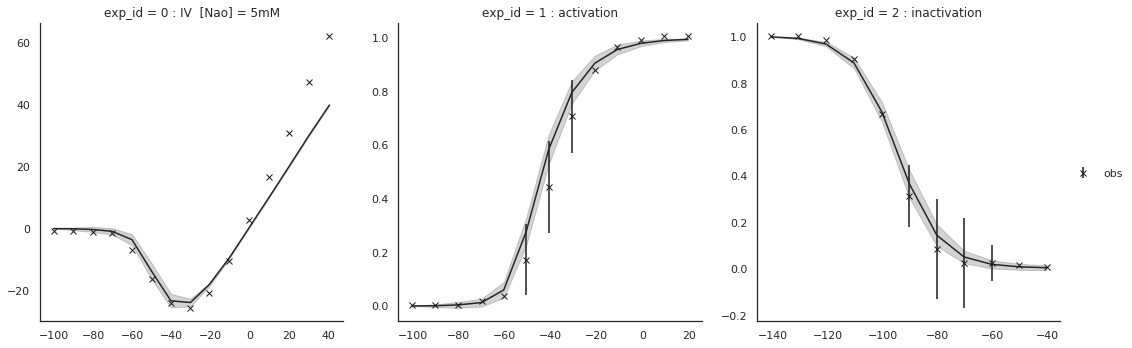

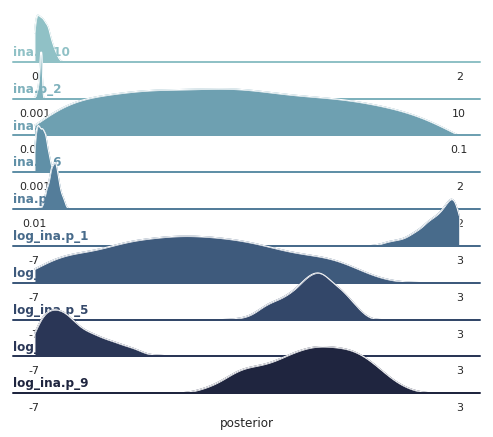

In [47]:
history = History(db_path)
history.id = 14 # 5 : pop size 10 to debug
# 8 : recovery sakakibara HP = -100 mV 
# 9 : availability HP = -80 mV
# 13 : time constants 
# 14 : IV 5 mM, act and inact
df, w = history.get_distribution(m=0)


grid1 = plot_sim_results(modelfile,sakakibara_iv_Nao5,
                         sakakibara_act,
                         sakakibara_inact, df=df, w=w,n_samples=100) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)


In [48]:
grid1.savefig('results/Ina Simple model/ina_simple_exp_iv_act_inact_saka_pop_2000.pdf')
grid2.savefig('results/Ina Simple model/ina_simple_post_iv_act_inact_saka_pop_2000.pdf')
#grid2.savefig('results/ina_nygren_posterior_recovery_saka_pop_10000.pdf')
#grid1.savefig('results/ina_nygren_experiments_recovery_saka__pop_10000.pdf')